In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

In [3]:
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [5]:
target_size = 224

seed = 42
device = "cuda"

In [6]:
data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [7]:
data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

In [8]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['person', 'person', 'train'], class_id=[14, 14, 18], bounding_boxes=[[80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81], [112.0, 93.0, 224, 186]])

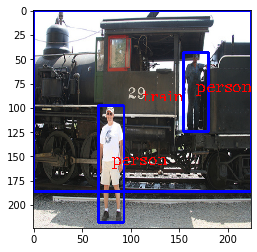

In [9]:
img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
anchor_grid = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [11]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [12]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [13]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [14]:
batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [15]:
class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class UpsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels, p, scale_factor=2):
        super().__init__()
        self.conv = StandardConv(out_channels, out_channels, p, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")

    def forward(self, x, x_upsample):
        x = self.upsample(x_upsample) + x
        x = self.conv(x)
        return x

class FPN(nn.Module):
    def __init__(self, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([StandardConv(512, 256, p[1], stride=1),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1])
        ])

        self.upsample = nn.ModuleList([UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1], scale_factor=7/4)
            
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)
        x = self.std_conv[0](x)

        x7 = x.clone()
        x4 = self.std_conv[1](x7)
        x2 = self.std_conv[2](x4)
        x1 = self.std_conv[3](x2)

        x_upsample_2 = self.upsample[0](x2, x1)
        x_upsample_4 = self.upsample[1](x4, x_upsample_2)
        x_upsample_7 = self.upsample[2](x7, x_upsample_4)

        return (x_upsample_7, x_upsample_4, x_upsample_2, x1)

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)), 
                self.flatten_conv(self.conv_2(x))]

class RetinaNet(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()
        self.fpn = FPN(p)
        self.fpn.change_freezing(False)

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        fpn_out = self.fpn(x)

        output_class_7, output_bb_7 = self.out_conv[0](fpn_out[0])
        output_class_4, output_bb_4 = self.out_conv[1](fpn_out[1])
        output_class_2, output_bb_2 = self.out_conv[2](fpn_out[2])
        output_class_1, output_bb_1 = self.out_conv[3](fpn_out[3])

        return [torch.cat([output_class_7, output_class_4, output_class_2, output_class_1], dim=1),
                torch.cat([output_bb_7, output_bb_4, output_bb_2, output_bb_1], dim=1)
               ]

In [16]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)
    
    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [18]:
class Loss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = Loss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = Loss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [19]:
loc_factor = 10.0
jaccard_overlap = 0.6

loss = Loss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

In [20]:
p = [0.2, 0.5]

torch.manual_seed(seed)
model = RetinaNet(num_boxes=num_boxes, p=p).to(device)

In [21]:
n_epochs = 40
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [22]:
jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

In [23]:
torch.manual_seed(seed)
random.seed(seed)
for epoch in range(n_epochs+1):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()
        train_class_loss += batch_class.detach().cpu().numpy()
        train_loc_loss += batch_loc.detach().cpu().numpy()

    train_loss =  np.round(train_loss / len(train_loader), 6)
    train_loc_loss =  np.round(train_loc_loss / len(train_loader), 6)
    train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(val_loader):
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        val_loss += batch_loss.detach().cpu().numpy()
        val_loc_loss += batch_loc.detach().cpu().numpy()
        val_class_loss += batch_class.detach().cpu().numpy()

    val_loss = np.round(val_loss / len(val_loader), 6)
    val_loc_loss = np.round(val_loc_loss / len(val_loader), 6)
    val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if epoch % 5 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Train loc loss: {train_loc_loss}")
        print(f"Train class loss: {train_class_loss}")
        print(f"Val loss: {val_loss}")
        print(f"Val loc loss: {val_loc_loss}")
        print(f"Val class loss: {val_class_loss}")
        print(f"Val mAP: {mAP}")

----- Epoch 0 -----
Train loss: 45.774851
Train loc loss: 0.290394
Train class loss: 42.870915
Val loss: 8.366414
Val loc loss: 0.25411
Val class loss: 5.825313
Val mAP: 0.108365
----- Epoch 5 -----
Train loss: 5.866539
Train loc loss: 0.177852
Train class loss: 4.088023
Val loss: 6.556388
Val loc loss: 0.222551
Val class loss: 4.330874
Val mAP: 0.252306
----- Epoch 10 -----
Train loss: 5.303864
Train loc loss: 0.159126
Train class loss: 3.712606
Val loss: 5.666514
Val loc loss: 0.181835
Val class loss: 3.84816
Val mAP: 0.337305
----- Epoch 15 -----
Train loss: 4.92535
Train loc loss: 0.146746
Train class loss: 3.457886
Val loss: 5.522846
Val loc loss: 0.171615
Val class loss: 3.806699
Val mAP: 0.383084
----- Epoch 20 -----
Train loss: 4.706971
Train loc loss: 0.14083
Train class loss: 3.298671
Val loss: 5.297659
Val loc loss: 0.158756
Val class loss: 3.710095
Val mAP: 0.406356
----- Epoch 25 -----
Train loss: 4.546192
Train loc loss: 0.136482
Train class loss: 3.181375
Val loss: 4.985

In [24]:
background_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename

In [25]:
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)

In [26]:
# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]

In [27]:
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []

In [28]:
output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

In [29]:
filtered_bb = non_max_suppression(output_bb)

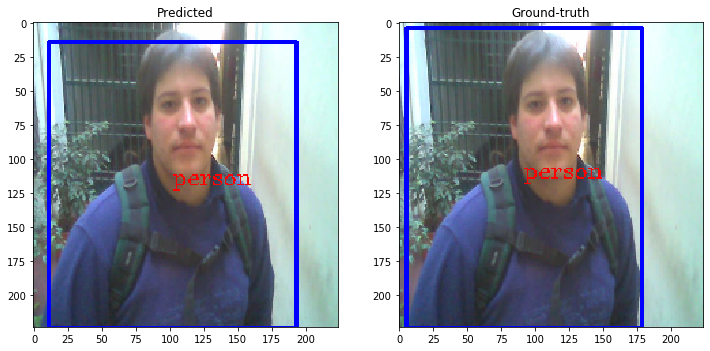

In [30]:
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()